# Week 7 Notebook for LSTM model building. Need to get a MAPE value for the poster.

In [100]:
from _Setup import *
from _Functions import *

In [81]:
# Import the scaler
with open(scalers_file, "rb") as file:
    scalers = pickle.load(file)
    
sector_train = pd.read_csv(sector_data_csv_path_train_pivoted, index_col='Area of Responsibility')

# Ensure scalers work
atlanta_scaler_info = scalers['Atlanta Field Office']
print(atlanta_scaler_info)

# Display the min and max values used for scaling
print("Min values:", atlanta_scaler_info.data_min_)
print("Max values:", atlanta_scaler_info.data_max_)

# Display the feature range
print("Feature range:", atlanta_scaler_info.feature_range)

# Display the scale and min values used for transformation
print("Scale:", atlanta_scaler_info.scale_)
print("Min:", atlanta_scaler_info.min_)

MinMaxScaler()
Min values: [521.]
Max values: [2141.]
Feature range: (0, 1)
Scale: [0.00061728]
Min: [-0.32160494]


In [82]:
# Create an empty DataFrame to store scaled values
sector_train_scaled = pd.DataFrame(index=sector_train.index, columns=sector_train.columns)

# Apply each pre-trained scaler row-wise
for index, row in sector_train.iterrows():
	scaler = scalers[index]
	scaled_row = scaler.transform(row.values.reshape(-1, 1)).flatten()
	sector_train_scaled.loc[index] = scaled_row

In [83]:
test_data = pd.read_csv(sector_data_csv_path_test_pivoted, index_col='Area of Responsibility')

# LSTM Model building first run

In [ ]:
# Define the single top configuration
top_config = {
        'input_size': 18,
        'learning_rate': 0.0001,
        'dropout_1': 0.4,
        'dropout_2': 0.4,
        'dropout_3': 0.4,
        'units_1': 12,
        'units_2': 512,
        'units_3': 256,
        'units_4': 64,
        'units_5': 6,
        'batch_size': 128,
        'epochs': 100,
        'patience': 5
    }
# Initialize a DataFrame to store the results
top_model_results = pd.DataFrame(columns=["config_id", "sector", "train_loss", "val_loss", "predictions", "MAPE"])

# Use the single configuration to train the model
config_id = 1
train_data, val_data = validation_split(sector_train_scaled, train_size=top_config['input_size'], validation_size=6)

for index in sector_train_scaled.index:
    
    index_integer = sector_train_scaled.index.get_loc(index)

    # Convert the first index of train_data and val_data to numpy arrays
    split_index = top_config['input_size']
    
    train_data_np = np.array(train_data[index_integer][:split_index])
    train_data_y_np = np.array(val_data[index_integer][:split_index])
    val_data_np = np.array(train_data[index_integer][split_index:])
    val_data_y_np = np.array(val_data[index_integer][split_index:])
    
    # Check the shapes of the data
    print(f'Train data shape for {index}: {train_data_np.shape}')
    print(f'Validation data shape for {index}: {val_data_np.shape}')
    
    # Reshape the data to fit the model's input requirements for LSTM
    train_data_np = train_data_np.reshape(-1, top_config['input_size'], 1)
    train_data_y_np = train_data_y_np.reshape(-1, 6)
    val_data_np = val_data_np.reshape(-1, top_config['input_size'], 1)
    val_data_y_np = val_data_y_np.reshape(-1, 6)
    
    # Convert numpy arrays to tensors
    train_data_tensor = tf.convert_to_tensor(train_data_np, dtype=tf.float32)
    train_data_y_tensor = tf.convert_to_tensor(train_data_y_np, dtype=tf.float32)
    val_data_tensor = tf.convert_to_tensor(val_data_np, dtype=tf.float32)
    val_data_y_tensor = tf.convert_to_tensor(val_data_y_np, dtype=tf.float32)

    optimizer = Adam(learning_rate=top_config['learning_rate'])

    # Define the LSTM neural network model
    nn_model = Sequential()
    nn_model.add(InputLayer(shape=(top_config['input_size'], 1)))
    nn_model.add(LSTM(units=top_config['units_1'], return_sequences=True))
    nn_model.add(Dropout(top_config['dropout_1']))
    nn_model.add(LSTM(units=top_config['units_2'], return_sequences=True))
    nn_model.add(Dropout(top_config['dropout_2']))
    nn_model.add(LSTM(units=top_config['units_3'], return_sequences=True))
    nn_model.add(Dropout(top_config['dropout_3']))
    nn_model.add(LSTM(units=top_config['units_4']))
    nn_model.add(Dense(units=top_config['units_5'], activation='linear'))  # Adjust the output layer to match the target shape

    nn_model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=top_config['patience'], restore_best_weights=True)
    
    # Train the model
    train_progress = nn_model.fit(train_data_tensor, train_data_y_tensor, epochs=top_config['epochs'], batch_size=top_config['batch_size'], validation_data=(val_data_tensor, val_data_y_tensor), callbacks=[early_stopping], verbose=1)  

    test_input = np.array(sector_train_scaled.iloc[index_integer][-top_config['input_size']:]).reshape(-1, top_config['input_size'], 1)
    test_input_tensor = tf.convert_to_tensor(test_input, dtype=tf.float32)
    predictions = nn_model.predict(test_input_tensor)
    current_sector_train = sector_train.loc[index]
    current_sector_actual = test_data.loc[index]
    predictions = scalers[index].inverse_transform(predictions)

    # Calculate MAPE for each time step
    mape_by_time_step = mean_absolute_percentage_error(current_sector_actual.values, predictions.flatten())
    sector_predictions = predictions.flatten()

    # Store the results in the DataFrame
    top_model_results = pd.concat([top_model_results, pd.DataFrame({
        "config_id": [config_id],
        "sector": [index],
        "train_loss": [train_progress.history['loss']],
        "val_loss": [train_progress.history['val_loss']],
        "predictions": [predictions.flatten()],
        "MAPE": [mape_by_time_step]
    })], ignore_index=True)

# Save the results to a pickle file
with open(lstm_mape_results_file, "wb") as file:
    pickle.dump(top_model_results, file)


Train data shape for Atlanta Field Office: (18, 18)
Validation data shape for Atlanta Field Office: (16, 18)
Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.2654 - val_loss: 0.1391
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step - loss: 0.2569 - val_loss: 0.1319
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step - loss: 0.2493 - val_loss: 0.1248
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step - loss: 0.2416 - val_loss: 0.1178
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step - loss: 0.2341 - val_loss: 0.1108
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step - loss: 0.2263 - val_loss: 0.1036
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step - loss: 0.2178 - val_loss: 0.0964
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step - loss: 0.2062 - val_loss: 0.0889
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step - loss: 0.2009 - val_loss: 0.0812
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step - loss: 0.1910 - val_loss: 0.0734
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

# Run 1 evaluation

In [ ]:
# Load the pickle file into a DataFrame
with open(lstm_mape_results_file, 'rb') as file:
    lstm_model_results = pickle.load(file)
    
# Initialize a DataFrame to store the average MAPE for each config_id
average_mape_results = pd.DataFrame()

# Get the unique config_ids
config_ids = lstm_model_results['config_id'].unique()

# Iterate through each config_id
for config_id in config_ids:
    # Filter the model_results DataFrame to only include rows for the current config_id
    filtered_results = lstm_model_results[lstm_model_results['config_id'] == config_id]

    # Create a DataFrame to store MAPE values for each sector
    mape_df = pd.DataFrame(columns=range(6))

    # Iterate through the filtered results and extract MAPE values
    for index, row in filtered_results.iterrows():
        mape_df.loc[row['sector']] = row['MAPE']

    # Calculate the mean MAPE for each time step
    average_mape = mape_df.mean()

    # Create a DataFrame to store the average MAPE for each time step
    average_mape_df = pd.DataFrame(average_mape, columns=[f'config_id_{config_id}'])

    # Append the average MAPE for the current config_id to the results DataFrame
    average_mape_results = pd.concat([average_mape_results, average_mape_df], axis=1)

MAPE for each time step

In [113]:
average_mape_results

,config_id_1
0,63.735507
1,68.299725
2,61.327646
3,71.035426
4,168.145383
5,141.942484


Average Mape for this model, not too shabby, comparable to NN 

In [114]:
# Calculate the mean of each column
column_means = average_mape_results.mean()

print("After more tuning, average mape is now:")
print(column_means)

After more tuning, average mape is now:
config_id_1    95.747695
dtype: float64


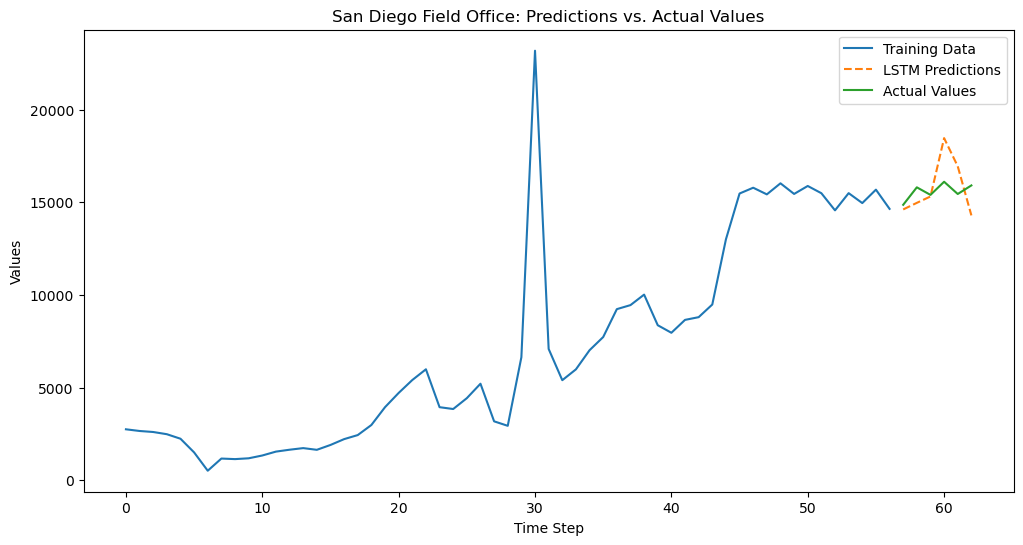

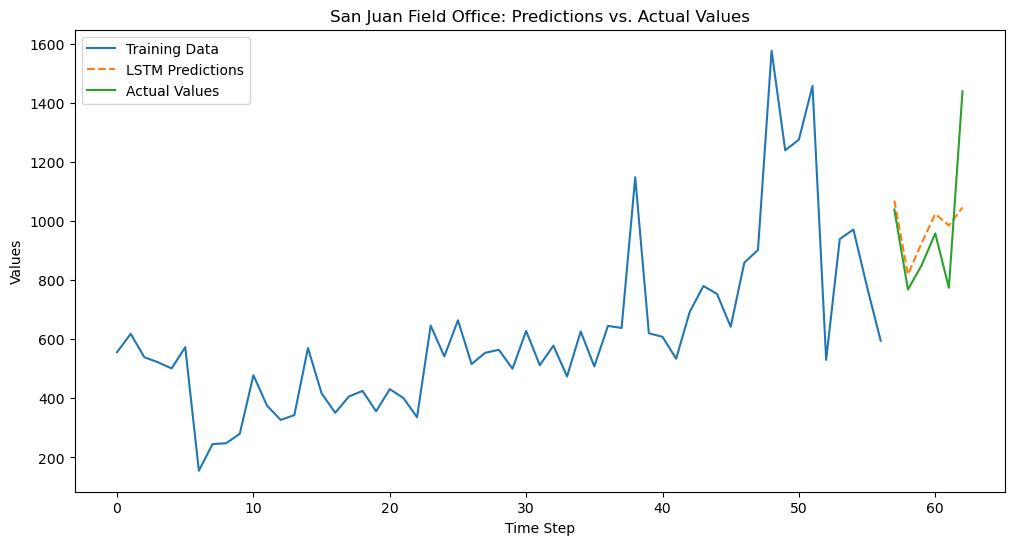

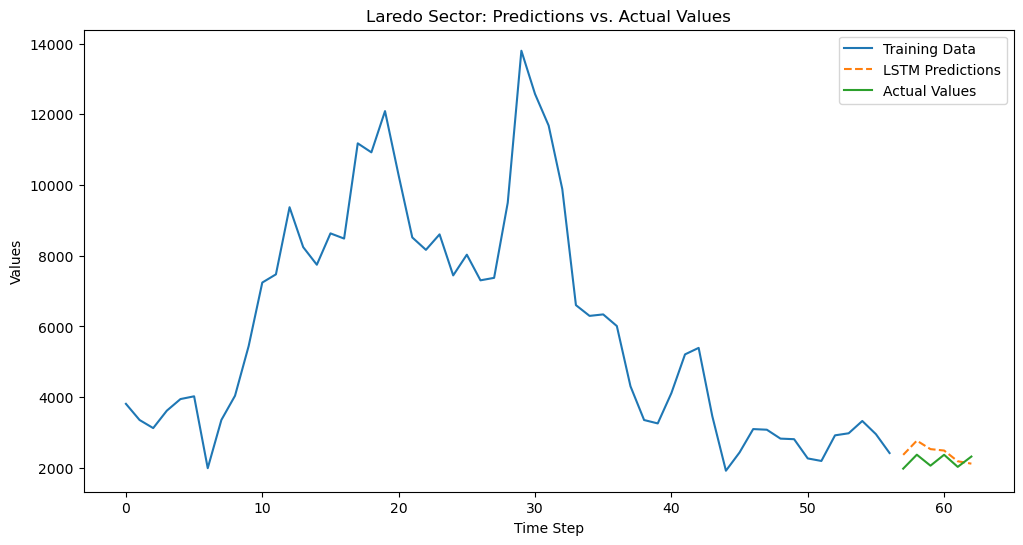

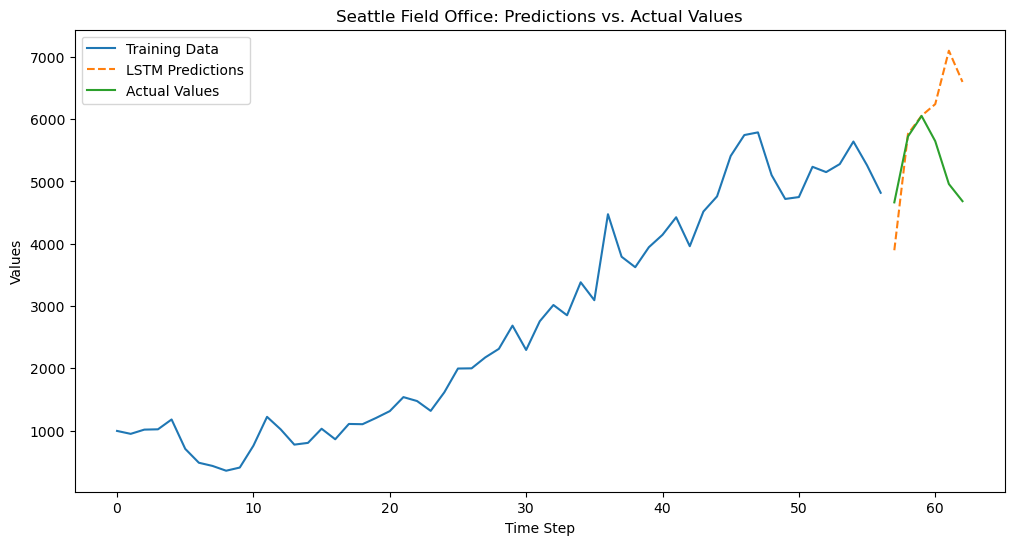

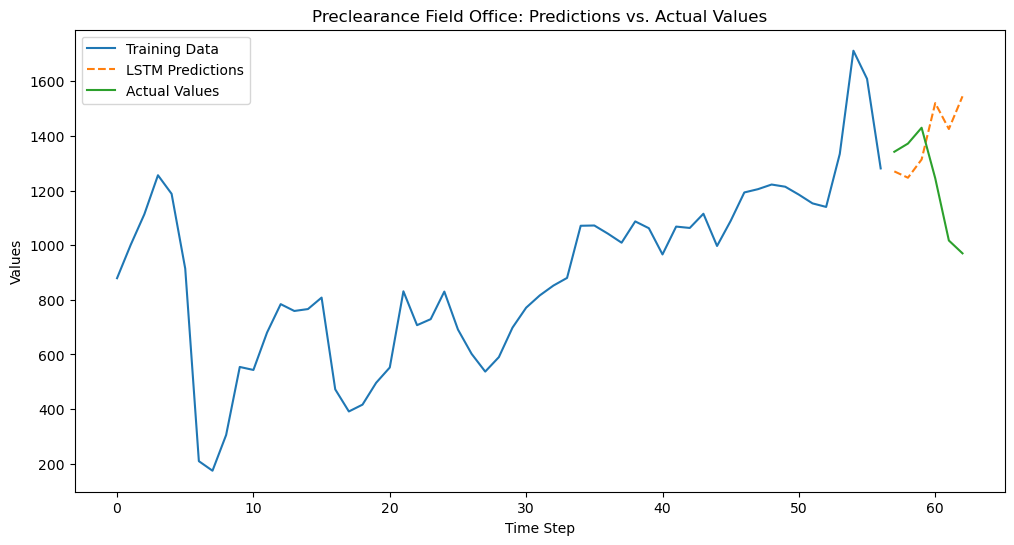

In [116]:
# Calculate the mean MAPE for each sector
mean_mape_per_sector = lstm_model_results.groupby('sector')['MAPE'].apply(lambda x: np.mean([item for sublist in x for item in sublist]))

# Find the top 5 sectors with the lowest mean MAPE
top_5_sectors = mean_mape_per_sector.nsmallest(5).index

# Plot predictions vs. actual values for the top 5 sectors
for sector in top_5_sectors:
    sector_results = lstm_model_results[lstm_model_results['sector'] == sector]

    # Extract predictions and actual values
    sector_predictions = np.concatenate(sector_results['predictions'].values)
    sector_actual = test_data.loc[sector].values[:len(sector_predictions)]
    sector_actual_train = sector_train.loc[sector].values

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(sector_actual_train, label='Training Data')
    plt.plot(range(len(sector_actual_train), len(sector_actual_train) + len(sector_predictions)), sector_predictions, label='LSTM Predictions', linestyle='--')
    plt.plot(range(len(sector_actual_train), len(sector_actual_train) + len(sector_actual)), sector_actual, label='Actual Values')
    plt.title(f'{sector}: Predictions vs. Actual Values')
    plt.xlabel('Time Step')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

# Run #2, let's see if we can improve MAPE 

Dropped dropout rate further down

In [124]:
# Define the configuration
top_config = {
        'input_size': 18,
        'learning_rate': 0.0001,
        'dropout_1': 0.3,
        'dropout_2': 0.3,
        'dropout_3': 0.3,
        'units_1': 12,
        'units_2': 512,
        'units_3': 256,
        'units_4': 64,
        'units_5': 6,
        'batch_size': 128,
        'epochs': 100,
        'patience': 5
    }
# Initialize a DataFrame to store the results
top_model_results = pd.DataFrame(columns=["config_id", "sector", "train_loss", "val_loss", "predictions", "MAPE"])

# Use the single configuration to train the model
config_id = 1
train_data, val_data = validation_split(sector_train_scaled, train_size=top_config['input_size'], validation_size=6)

for index in sector_train_scaled.index:
    
    index_integer = sector_train_scaled.index.get_loc(index)

    # Convert the first index of train_data and val_data to numpy arrays
    split_index = top_config['input_size']
    
    train_data_np = np.array(train_data[index_integer][:split_index])
    train_data_y_np = np.array(val_data[index_integer][:split_index])
    val_data_np = np.array(train_data[index_integer][split_index:])
    val_data_y_np = np.array(val_data[index_integer][split_index:])
    
    # Check the shapes of the data
    print(f'Train data shape for {index}: {train_data_np.shape}')
    print(f'Validation data shape for {index}: {val_data_np.shape}')
    
    # Reshape the data to fit the model's input requirements for LSTM
    train_data_np = train_data_np.reshape(-1, top_config['input_size'], 1)
    train_data_y_np = train_data_y_np.reshape(-1, 6)
    val_data_np = val_data_np.reshape(-1, top_config['input_size'], 1)
    val_data_y_np = val_data_y_np.reshape(-1, 6)
    
    # Convert numpy arrays to tensors
    train_data_tensor = tf.convert_to_tensor(train_data_np, dtype=tf.float32)
    train_data_y_tensor = tf.convert_to_tensor(train_data_y_np, dtype=tf.float32)
    val_data_tensor = tf.convert_to_tensor(val_data_np, dtype=tf.float32)
    val_data_y_tensor = tf.convert_to_tensor(val_data_y_np, dtype=tf.float32)

    optimizer = Adam(learning_rate=top_config['learning_rate'])

    # Define the LSTM neural network model
    nn_model = Sequential()
    nn_model.add(InputLayer(shape=(top_config['input_size'], 1)))
    nn_model.add(LSTM(units=top_config['units_1'], return_sequences=True))
    nn_model.add(Dropout(top_config['dropout_1']))
    nn_model.add(LSTM(units=top_config['units_2'], return_sequences=True))
    nn_model.add(Dropout(top_config['dropout_2']))
    nn_model.add(LSTM(units=top_config['units_3'], return_sequences=True))
    nn_model.add(Dropout(top_config['dropout_3']))
    nn_model.add(LSTM(units=top_config['units_4']))
    nn_model.add(Dense(units=top_config['units_5'], activation='linear'))  # Adjust the output layer to match the target shape

    nn_model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=top_config['patience'], restore_best_weights=True)
    
    # Train the model
    train_progress = nn_model.fit(train_data_tensor, train_data_y_tensor, epochs=top_config['epochs'], batch_size=top_config['batch_size'], validation_data=(val_data_tensor, val_data_y_tensor), callbacks=[early_stopping], verbose=1)  

    test_input = np.array(sector_train_scaled.iloc[index_integer][-top_config['input_size']:]).reshape(-1, top_config['input_size'], 1)
    test_input_tensor = tf.convert_to_tensor(test_input, dtype=tf.float32)
    predictions = nn_model.predict(test_input_tensor)
    current_sector_train = sector_train.loc[index]
    current_sector_actual = test_data.loc[index]
    predictions = scalers[index].inverse_transform(predictions)

    # Calculate MAPE for each time step
    mape_by_time_step = mean_absolute_percentage_error(current_sector_actual.values, predictions.flatten())
    sector_predictions = predictions.flatten()

    # Store the results in the DataFrame
    top_model_results = pd.concat([top_model_results, pd.DataFrame({
        "config_id": [config_id],
        "sector": [index],
        "train_loss": [train_progress.history['loss']],
        "val_loss": [train_progress.history['val_loss']],
        "predictions": [predictions.flatten()],
        "MAPE": [mape_by_time_step]
    })], ignore_index=True)

# Save the results to a pickle file
with open("C:/AA-Capstone/Model_Outputs/lstm_model_results1.pkl", "wb") as file:
    pickle.dump(top_model_results, file)

Train data shape for Atlanta Field Office: (18, 18)
Validation data shape for Atlanta Field Office: (16, 18)
Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - loss: 0.2580 - val_loss: 0.1340
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.2516 - val_loss: 0.1285
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.2450 - val_loss: 0.1229
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2387 - val_loss: 0.1172
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.2327 - val_loss: 0.1114
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.2261 - val_loss: 0.1053
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.2181 - val_loss: 0.0989
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.2107 - val_loss: 0.0923
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.2026 - val_loss: 0.0853
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1938 - val_loss: 0.0780
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1844 - va

In [125]:
# Load the pickle file into a DataFrame
with open("C:/AA-Capstone/Model_Outputs/lstm_model_results1.pkl", 'rb') as file:
    lstm_model_results = pickle.load(file)
    
# Initialize a DataFrame to store the average MAPE for each config_id
average_mape_results = pd.DataFrame()

# Get the unique config_ids
config_ids = lstm_model_results['config_id'].unique()

# Iterate through each config_id
for config_id in config_ids:
    # Filter the model_results DataFrame to only include rows for the current config_id
    filtered_results = lstm_model_results[lstm_model_results['config_id'] == config_id]

    # Create a DataFrame to store MAPE values for each sector
    mape_df = pd.DataFrame(columns=range(6))

    # Iterate through the filtered results and extract MAPE values
    for index, row in filtered_results.iterrows():
        mape_df.loc[row['sector']] = row['MAPE']

    # Calculate the mean MAPE for each time step
    average_mape = mape_df.mean()

    # Create a DataFrame to store the average MAPE for each time step
    average_mape_df = pd.DataFrame(average_mape, columns=[f'config_id_{config_id}'])

    # Append the average MAPE for the current config_id to the results DataFrame
    average_mape_results = pd.concat([average_mape_results, average_mape_df], axis=1)

In [126]:
average_mape_results

,config_id_1
0,68.159420
1,69.374985
2,75.719568
3,75.224711
4,140.334140
5,130.833956


Looks to have improved the MAPE at the later time steps (5 and 6!)

In [127]:
# Calculate the mean of each column
column_means = average_mape_results.mean()

print("After more tuning, average mape is now:")
print(column_means)

After more tuning, average mape is now:
config_id_1    93.274463
dtype: float64


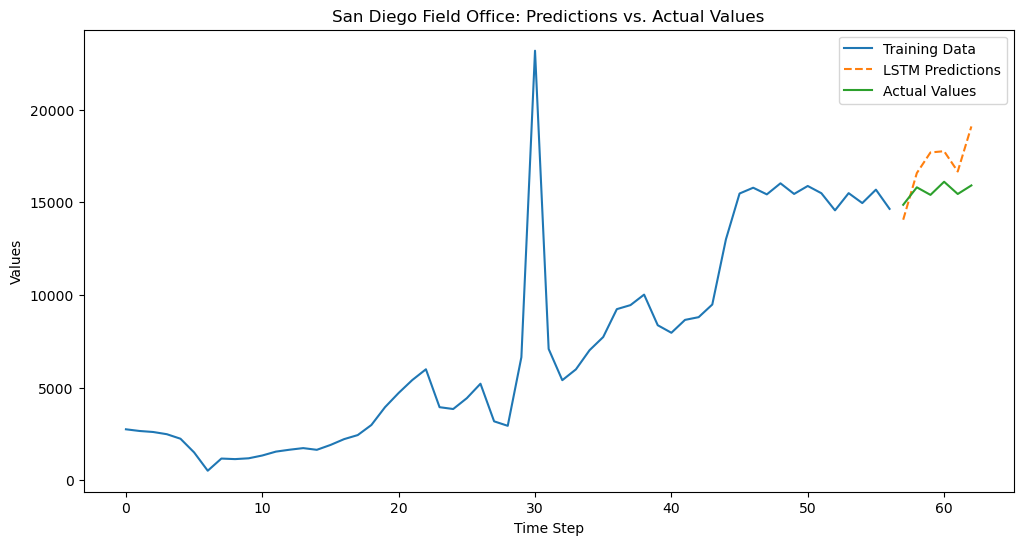

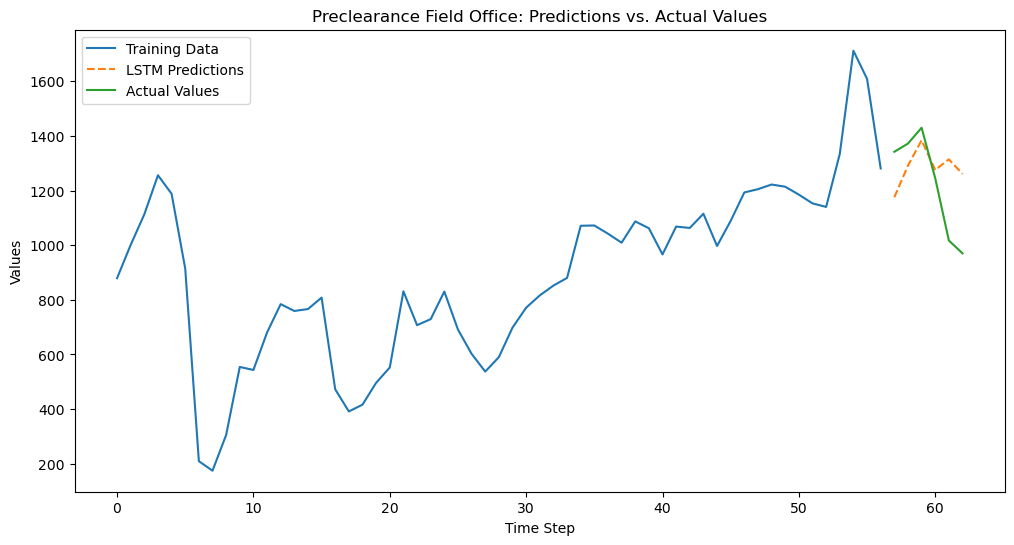

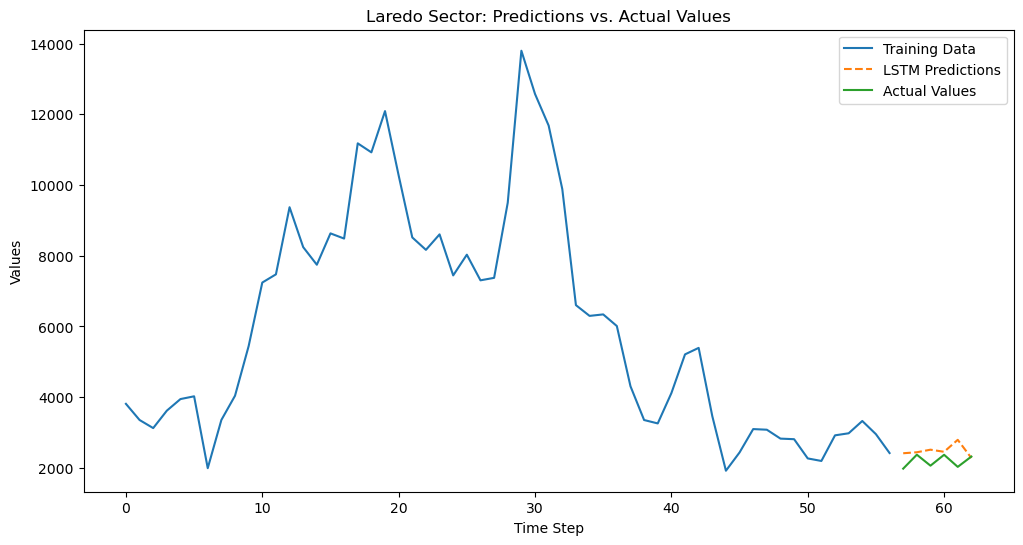

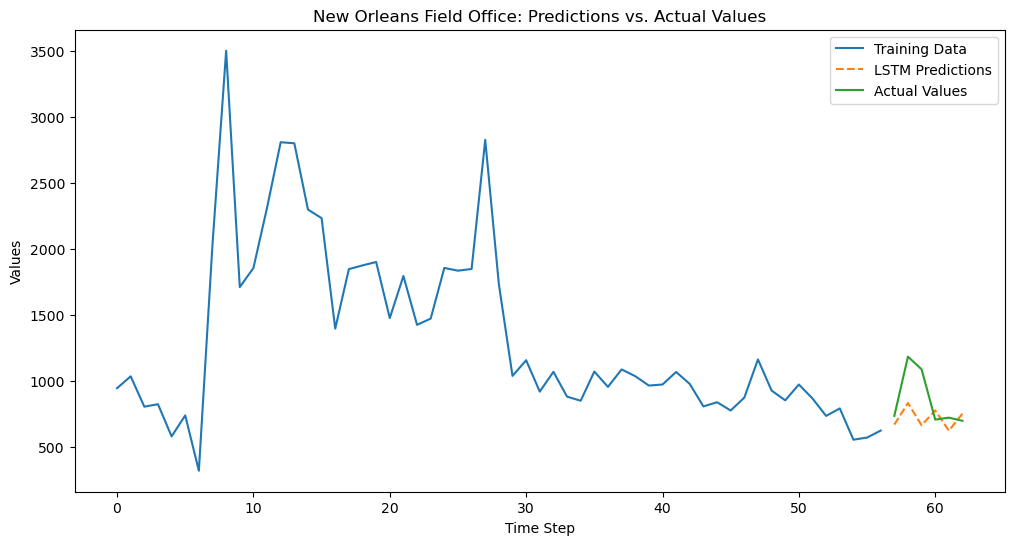

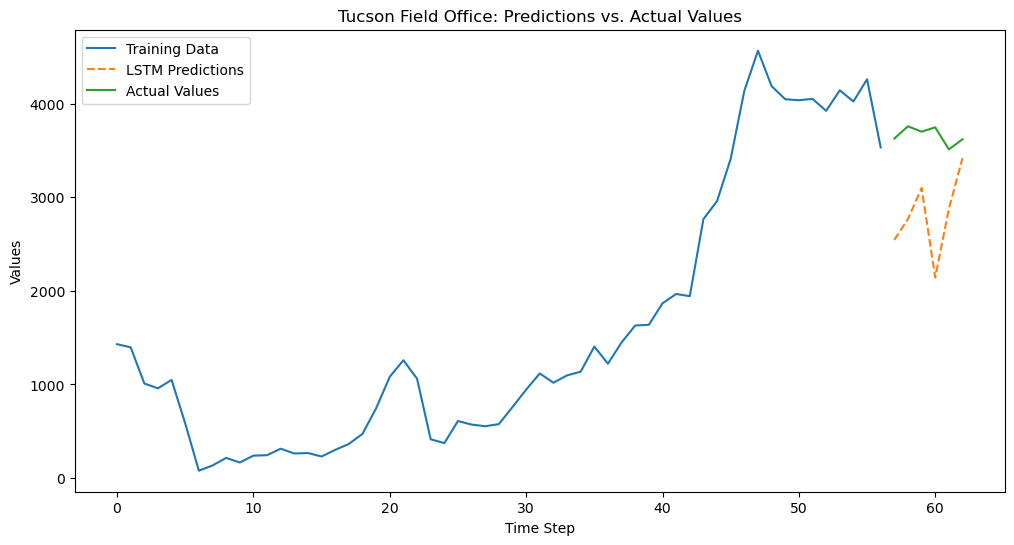

In [128]:
# Calculate the mean MAPE for each sector
mean_mape_per_sector = lstm_model_results.groupby('sector')['MAPE'].apply(lambda x: np.mean([item for sublist in x for item in sublist]))

# Find the top 5 sectors with the lowest mean MAPE
top_5_sectors = mean_mape_per_sector.nsmallest(5).index

# Plot predictions vs. actual values for the top 5 sectors
for sector in top_5_sectors:
    sector_results = lstm_model_results[lstm_model_results['sector'] == sector]

    # Extract predictions and actual values
    sector_predictions = np.concatenate(sector_results['predictions'].values)
    sector_actual = test_data.loc[sector].values[:len(sector_predictions)]
    sector_actual_train = sector_train.loc[sector].values

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(sector_actual_train, label='Training Data')
    plt.plot(range(len(sector_actual_train), len(sector_actual_train) + len(sector_predictions)), sector_predictions, label='LSTM Predictions', linestyle='--')
    plt.plot(range(len(sector_actual_train), len(sector_actual_train) + len(sector_actual)), sector_actual, label='Actual Values')
    plt.title(f'{sector}: Predictions vs. Actual Values')
    plt.xlabel('Time Step')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

In [ ]:
# Define the configuration
top_config = {
        'input_size': 18,
        'learning_rate': 0.0005,
        'dropout_1': 0.4,
        'dropout_2': 0.3,
        'dropout_3': 0.3,
        'units_1': 12,
        'units_2': 256,
        'units_3': 128,
        'units_4': 64,
        'units_5': 6,
        'batch_size': 128,
        'epochs': 150,
        'patience': 5
    }
# Initialize a DataFrame to store the results
top_model_results = pd.DataFrame(columns=["config_id", "sector", "train_loss", "val_loss", "predictions", "MAPE"])

# Use the single configuration to train the model
config_id = 1
train_data, val_data = validation_split(sector_train_scaled, train_size=top_config['input_size'], validation_size=6)

for index in sector_train_scaled.index:
    
    index_integer = sector_train_scaled.index.get_loc(index)

    # Convert the first index of train_data and val_data to numpy arrays
    split_index = top_config['input_size']
    
    train_data_np = np.array(train_data[index_integer][:split_index])
    train_data_y_np = np.array(val_data[index_integer][:split_index])
    val_data_np = np.array(train_data[index_integer][split_index:])
    val_data_y_np = np.array(val_data[index_integer][split_index:])
    
    # Check the shapes of the data
    print(f'Train data shape for {index}: {train_data_np.shape}')
    print(f'Validation data shape for {index}: {val_data_np.shape}')
    
    # Reshape the data to fit the model's input requirements for LSTM
    train_data_np = train_data_np.reshape(-1, top_config['input_size'], 1)
    train_data_y_np = train_data_y_np.reshape(-1, 6)
    val_data_np = val_data_np.reshape(-1, top_config['input_size'], 1)
    val_data_y_np = val_data_y_np.reshape(-1, 6)
    
    # Convert numpy arrays to tensors
    train_data_tensor = tf.convert_to_tensor(train_data_np, dtype=tf.float32)
    train_data_y_tensor = tf.convert_to_tensor(train_data_y_np, dtype=tf.float32)
    val_data_tensor = tf.convert_to_tensor(val_data_np, dtype=tf.float32)
    val_data_y_tensor = tf.convert_to_tensor(val_data_y_np, dtype=tf.float32)

    optimizer = Adam(learning_rate=top_config['learning_rate'])

    # Define the LSTM neural network model
    nn_model = Sequential()
    nn_model.add(InputLayer(shape=(top_config['input_size'], 1)))
    nn_model.add(LSTM(units=top_config['units_1'], return_sequences=True))
    nn_model.add(Dropout(top_config['dropout_1']))
    nn_model.add(LSTM(units=top_config['units_2'], return_sequences=True))
    nn_model.add(Dropout(top_config['dropout_2']))
    nn_model.add(LSTM(units=top_config['units_3'], return_sequences=True))
    nn_model.add(Dropout(top_config['dropout_3']))
    nn_model.add(LSTM(units=top_config['units_4']))
    nn_model.add(Dense(units=top_config['units_5'], activation='linear'))  # Adjust the output layer to match the target shape

    nn_model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=top_config['patience'], restore_best_weights=True)
    
    # Train the model
    train_progress = nn_model.fit(train_data_tensor, train_data_y_tensor, epochs=top_config['epochs'], batch_size=top_config['batch_size'], validation_data=(val_data_tensor, val_data_y_tensor), callbacks=[early_stopping], verbose=1)  

    test_input = np.array(sector_train_scaled.iloc[index_integer][-top_config['input_size']:]).reshape(-1, top_config['input_size'], 1)
    test_input_tensor = tf.convert_to_tensor(test_input, dtype=tf.float32)
    predictions = nn_model.predict(test_input_tensor)
    current_sector_train = sector_train.loc[index]
    current_sector_actual = test_data.loc[index]
    predictions = scalers[index].inverse_transform(predictions)

    # Calculate MAPE for each time step
    mape_by_time_step = mean_absolute_percentage_error(current_sector_actual.values, predictions.flatten())
    sector_predictions = predictions.flatten()

    # Store the results in the DataFrame
    top_model_results = pd.concat([top_model_results, pd.DataFrame({
        "config_id": [config_id],
        "sector": [index],
        "train_loss": [train_progress.history['loss']],
        "val_loss": [train_progress.history['val_loss']],
        "predictions": [predictions.flatten()],
        "MAPE": [mape_by_time_step]
    })], ignore_index=True)

# Save the results to a pickle file
with open(lstm_mape_results_file2, "wb") as file:
    pickle.dump(top_model_results, file)

Train data shape for Atlanta Field Office: (18, 18)
Validation data shape for Atlanta Field Office: (16, 18)
Epoch 1/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - loss: 0.2656 - val_loss: 0.1307
Epoch 2/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - loss: 0.2473 - val_loss: 0.1151
Epoch 3/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - loss: 0.2295 - val_loss: 0.0989
Epoch 4/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 0.2098 - val_loss: 0.0815
Epoch 5/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step - loss: 0.1891 - val_loss: 0.0628
Epoch 6/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step - loss: 0.1611 - val_loss: 0.0444
Epoch 7/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - loss: 0.1318 - val_loss: 0.0303
Epoch 8/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - loss: 0.0992 - val_loss: 0.0309
Epoch 9/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - loss: 0.0699 - val_loss: 0.0649
Epoch 10/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - loss: 0.0498 - val_loss: 0.1368
Epoch 11/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
# Load the pickle file into a DataFrame
with open(lstm_mape_results_file2, 'rb') as file:
    lstm_model_results = pickle.load(file)
    
# Initialize a DataFrame to store the average MAPE for each config_id
average_mape_results = pd.DataFrame()

# Get the unique config_ids
config_ids = lstm_model_results['config_id'].unique()

# Iterate through each config_id
for config_id in config_ids:
    # Filter the model_results DataFrame to only include rows for the current config_id
    filtered_results = lstm_model_results[lstm_model_results['config_id'] == config_id]

    # Create a DataFrame to store MAPE values for each sector
    mape_df = pd.DataFrame(columns=range(6))

    # Iterate through the filtered results and extract MAPE values
    for index, row in filtered_results.iterrows():
        mape_df.loc[row['sector']] = row['MAPE']

    # Calculate the mean MAPE for each time step
    average_mape = mape_df.mean()

    # Create a DataFrame to store the average MAPE for each time step
    average_mape_df = pd.DataFrame(average_mape, columns=[f'config_id_{config_id}'])

    # Append the average MAPE for the current config_id to the results DataFrame
    average_mape_results = pd.concat([average_mape_results, average_mape_df], axis=1)

# Honestly, LSTM might be the way to go, these first four time steps are always pretty consistent

In [137]:
average_mape_results

,config_id_1
0,56.353804
1,66.398620
2,69.366560
3,69.144341
4,177.060785
5,130.924025


In [138]:
# Calculate the mean of each column
column_means = average_mape_results.mean()

print("After more tuning, average mape is now:")
print(column_means)

After more tuning, average mape is now:
config_id_1    94.874689
dtype: float64


Going to try one last configuration

In [ ]:
# Define the configuration
top_config = {
        'input_size': 18,
        'learning_rate': 0.001,
        'dropout_1': 0.4,
        'dropout_2': 0.3,
        'dropout_3': 0.3,
        'units_1': 12,
        'units_2': 64,
        'units_3': 128,
        'units_4': 64,
        'units_5': 6,
        'batch_size': 128,
        'epochs': 150,
        'patience': 5
    }
# Initialize a DataFrame to store the results
top_model_results = pd.DataFrame(columns=["config_id", "sector", "train_loss", "val_loss", "predictions", "MAPE"])

# Use the single configuration to train the model
config_id = 1
train_data, val_data = validation_split(sector_train_scaled, train_size=top_config['input_size'], validation_size=6)

for index in sector_train_scaled.index:
    
    index_integer = sector_train_scaled.index.get_loc(index)

    # Convert the first index of train_data and val_data to numpy arrays
    split_index = top_config['input_size']
    
    train_data_np = np.array(train_data[index_integer][:split_index])
    train_data_y_np = np.array(val_data[index_integer][:split_index])
    val_data_np = np.array(train_data[index_integer][split_index:])
    val_data_y_np = np.array(val_data[index_integer][split_index:])
    
    # Check the shapes of the data
    print(f'Train data shape for {index}: {train_data_np.shape}')
    print(f'Validation data shape for {index}: {val_data_np.shape}')
    
    # Reshape the data to fit the model's input requirements for LSTM
    train_data_np = train_data_np.reshape(-1, top_config['input_size'], 1)
    train_data_y_np = train_data_y_np.reshape(-1, 6)
    val_data_np = val_data_np.reshape(-1, top_config['input_size'], 1)
    val_data_y_np = val_data_y_np.reshape(-1, 6)
    
    # Convert numpy arrays to tensors
    train_data_tensor = tf.convert_to_tensor(train_data_np, dtype=tf.float32)
    train_data_y_tensor = tf.convert_to_tensor(train_data_y_np, dtype=tf.float32)
    val_data_tensor = tf.convert_to_tensor(val_data_np, dtype=tf.float32)
    val_data_y_tensor = tf.convert_to_tensor(val_data_y_np, dtype=tf.float32)

    optimizer = Adam(learning_rate=top_config['learning_rate'])

    # Define the LSTM neural network model
    nn_model = Sequential()
    nn_model.add(InputLayer(shape=(top_config['input_size'], 1)))
    nn_model.add(LSTM(units=top_config['units_1'], return_sequences=True))
    nn_model.add(Dropout(top_config['dropout_1']))
    nn_model.add(LSTM(units=top_config['units_2'], return_sequences=True))
    nn_model.add(Dropout(top_config['dropout_2']))
    nn_model.add(LSTM(units=top_config['units_3'], return_sequences=True))
    nn_model.add(Dropout(top_config['dropout_3']))
    nn_model.add(LSTM(units=top_config['units_4']))
    nn_model.add(Dense(units=top_config['units_5'], activation='linear'))  # Adjust the output layer to match the target shape

    nn_model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=top_config['patience'], restore_best_weights=True)
    
    # Train the model
    train_progress = nn_model.fit(train_data_tensor, train_data_y_tensor, epochs=top_config['epochs'], batch_size=top_config['batch_size'], validation_data=(val_data_tensor, val_data_y_tensor), callbacks=[early_stopping], verbose=1)  

    test_input = np.array(sector_train_scaled.iloc[index_integer][-top_config['input_size']:]).reshape(-1, top_config['input_size'], 1)
    test_input_tensor = tf.convert_to_tensor(test_input, dtype=tf.float32)
    predictions = nn_model.predict(test_input_tensor)
    current_sector_train = sector_train.loc[index]
    current_sector_actual = test_data.loc[index]
    predictions = scalers[index].inverse_transform(predictions)

    # Calculate MAPE for each time step
    mape_by_time_step = mean_absolute_percentage_error(current_sector_actual.values, predictions.flatten())
    sector_predictions = predictions.flatten()

    # Store the results in the DataFrame
    top_model_results = pd.concat([top_model_results, pd.DataFrame({
        "config_id": [config_id],
        "sector": [index],
        "train_loss": [train_progress.history['loss']],
        "val_loss": [train_progress.history['val_loss']],
        "predictions": [predictions.flatten()],
        "MAPE": [mape_by_time_step]
    })], ignore_index=True)

# Save the results to a pickle file
with open(lstm_mape_results_file3, "wb") as file:
    pickle.dump(top_model_results, file)

Train data shape for Atlanta Field Office: (18, 18)
Validation data shape for Atlanta Field Office: (16, 18)
Epoch 1/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 0.2569 - val_loss: 0.1214
Epoch 2/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - loss: 0.2356 - val_loss: 0.1025
Epoch 3/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - loss: 0.2126 - val_loss: 0.0802
Epoch 4/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - loss: 0.1849 - val_loss: 0.0543
Epoch 5/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - loss: 0.1489 - val_loss: 0.0289
Epoch 6/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - loss: 0.0991 - val_loss: 0.0196
Epoch 7/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - loss: 0.0531 - val_loss: 0.0735
Epoch 8/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - loss: 0.0339 - val_loss: 0.2178
Epoch 9/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - loss: 0.0834 - val_loss: 0.2010
Epoch 10/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - loss: 0.0725 - val_loss: 0.1274
Epoch 11/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
# Load the pickle file into a DataFrame
with open(lstm_mape_results_file3, 'rb') as file:
    lstm_model_results = pickle.load(file)
    
# Initialize a DataFrame to store the average MAPE for each config_id
average_mape_results = pd.DataFrame()

# Get the unique config_ids
config_ids = lstm_model_results['config_id'].unique()

# Iterate through each config_id
for config_id in config_ids:
    # Filter the model_results DataFrame to only include rows for the current config_id
    filtered_results = lstm_model_results[lstm_model_results['config_id'] == config_id]

    # Create a DataFrame to store MAPE values for each sector
    mape_df = pd.DataFrame(columns=range(6))

    # Iterate through the filtered results and extract MAPE values
    for index, row in filtered_results.iterrows():
        mape_df.loc[row['sector']] = row['MAPE']

    # Calculate the mean MAPE for each time step
    average_mape = mape_df.mean()

    # Create a DataFrame to store the average MAPE for each time step
    average_mape_df = pd.DataFrame(average_mape, columns=[f'config_id_{config_id}'])

    # Append the average MAPE for the current config_id to the results DataFrame
    average_mape_results = pd.concat([average_mape_results, average_mape_df], axis=1)

In [142]:
average_mape_results

,config_id_1
0,66.184431
1,65.879444
2,67.675298
3,77.678811
4,161.866781
5,114.597093


In [143]:
# Calculate the mean of each column
column_means = average_mape_results.mean()

print("After more tuning, average mape is now:")
print(column_means)

After more tuning, average mape is now:
config_id_1    92.313643
dtype: float64


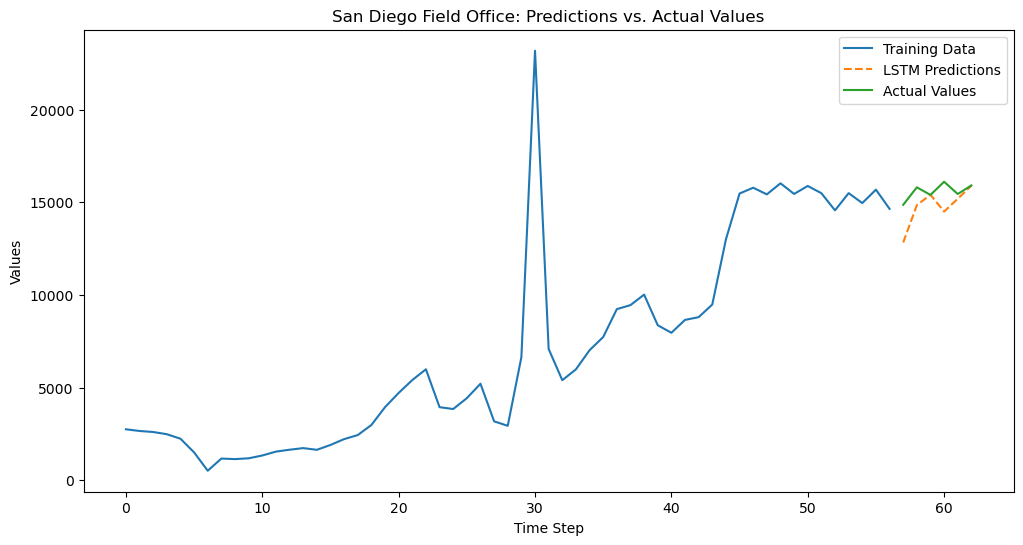

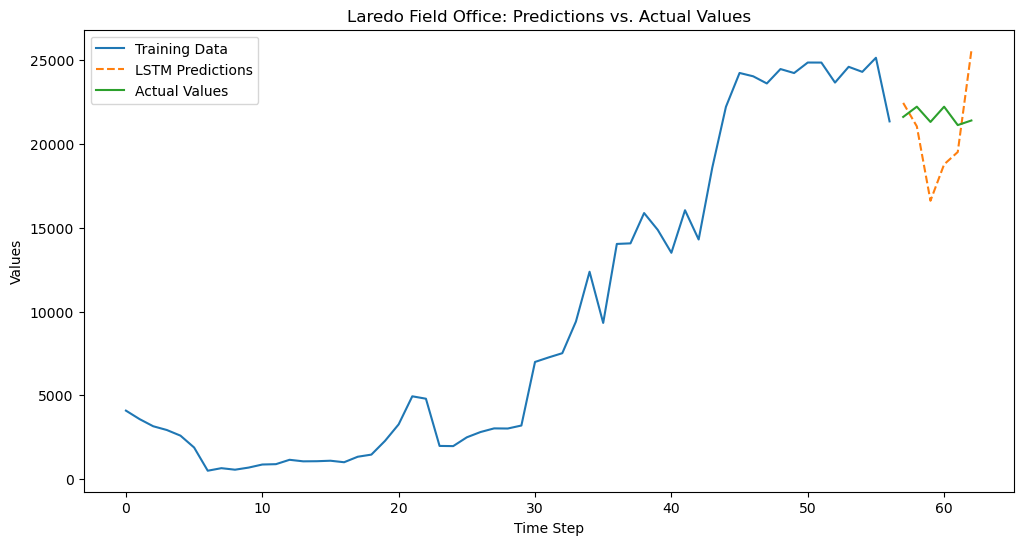

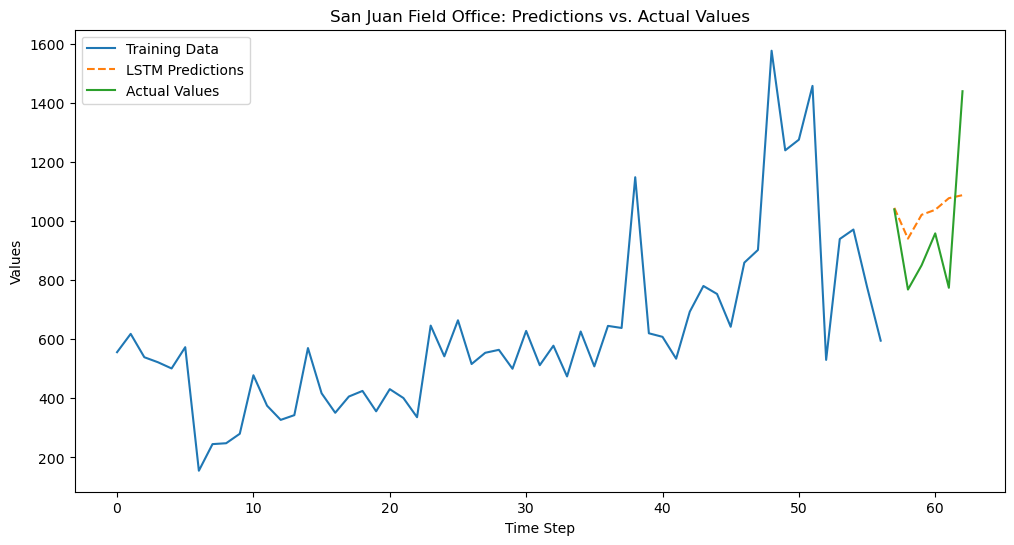

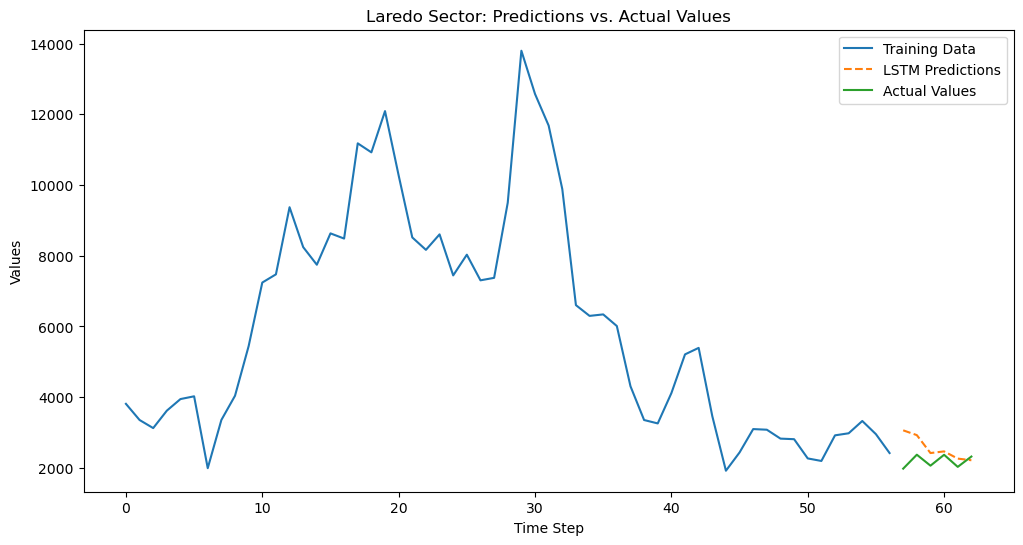

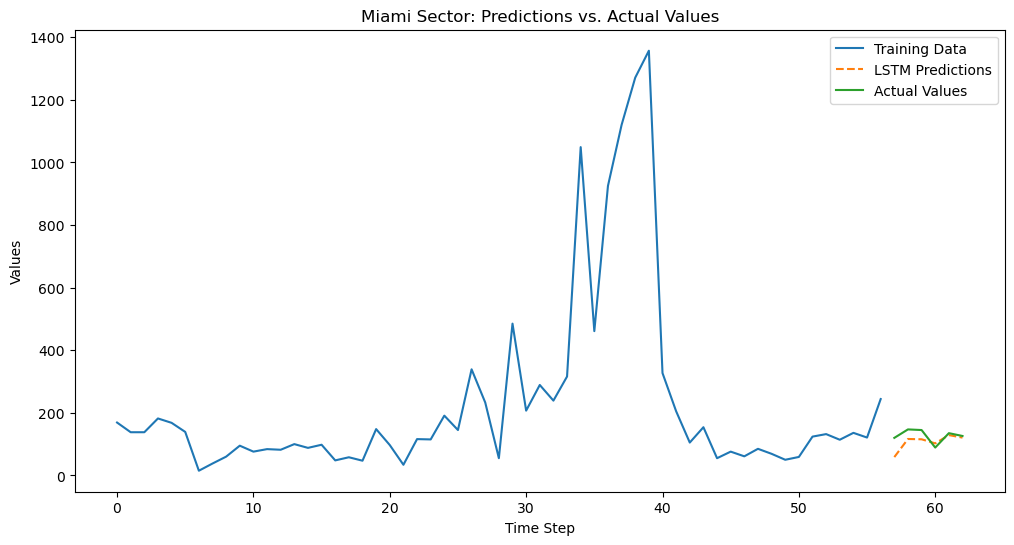

In [144]:
# Calculate the mean MAPE for each sector
mean_mape_per_sector = lstm_model_results.groupby('sector')['MAPE'].apply(lambda x: np.mean([item for sublist in x for item in sublist]))

# Find the top 5 sectors with the lowest mean MAPE
top_5_sectors = mean_mape_per_sector.nsmallest(5).index

# Plot predictions vs. actual values for the top 5 sectors
for sector in top_5_sectors:
    sector_results = lstm_model_results[lstm_model_results['sector'] == sector]

    # Extract predictions and actual values
    sector_predictions = np.concatenate(sector_results['predictions'].values)
    sector_actual = test_data.loc[sector].values[:len(sector_predictions)]
    sector_actual_train = sector_train.loc[sector].values

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(sector_actual_train, label='Training Data')
    plt.plot(range(len(sector_actual_train), len(sector_actual_train) + len(sector_predictions)), sector_predictions, label='LSTM Predictions', linestyle='--')
    plt.plot(range(len(sector_actual_train), len(sector_actual_train) + len(sector_actual)), sector_actual, label='Actual Values')
    plt.title(f'{sector}: Predictions vs. Actual Values')
    plt.xlabel('Time Step')
    plt.ylabel('Values')
    plt.legend()
    plt.show()